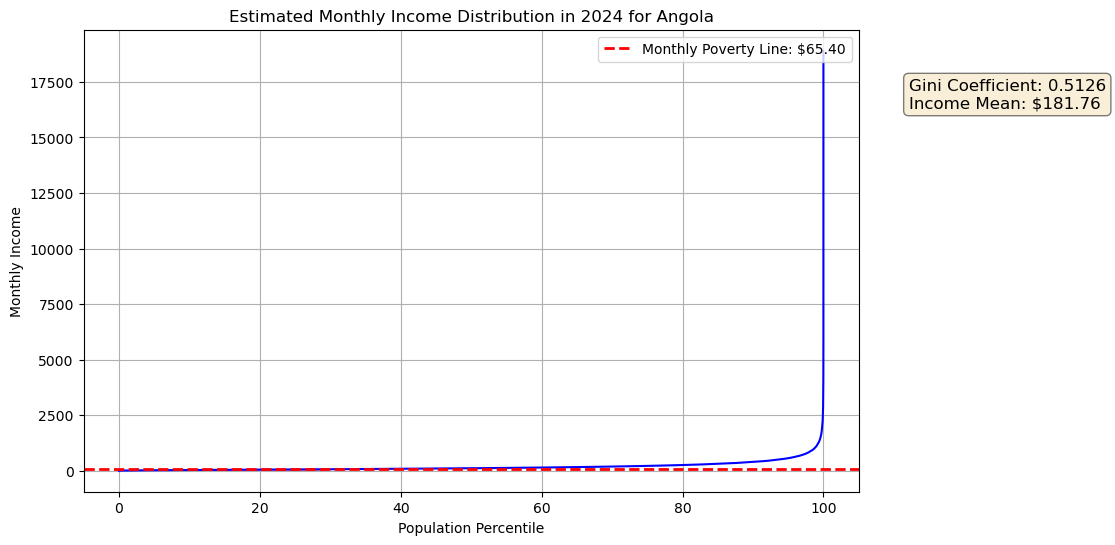

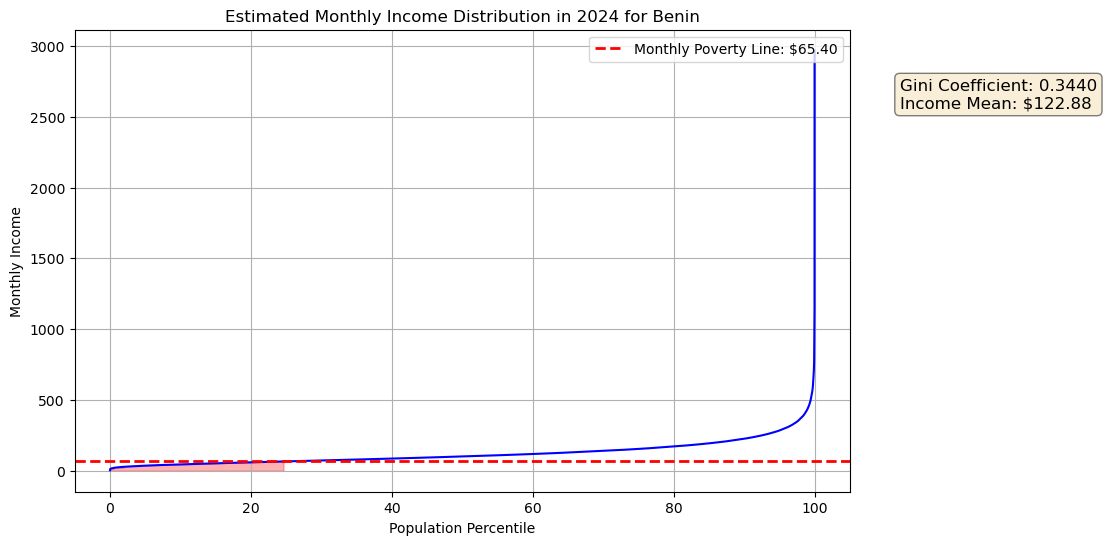

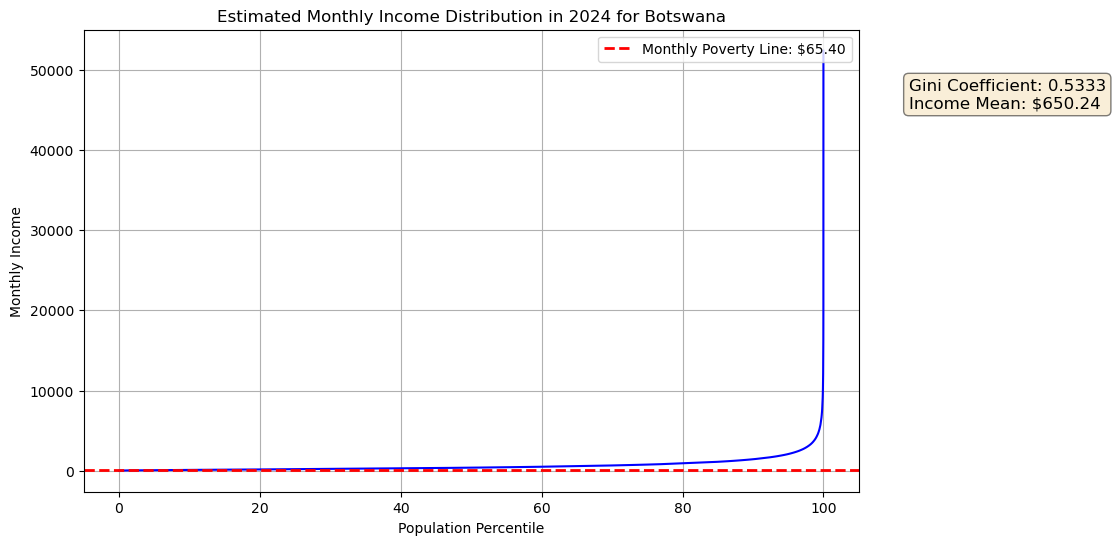

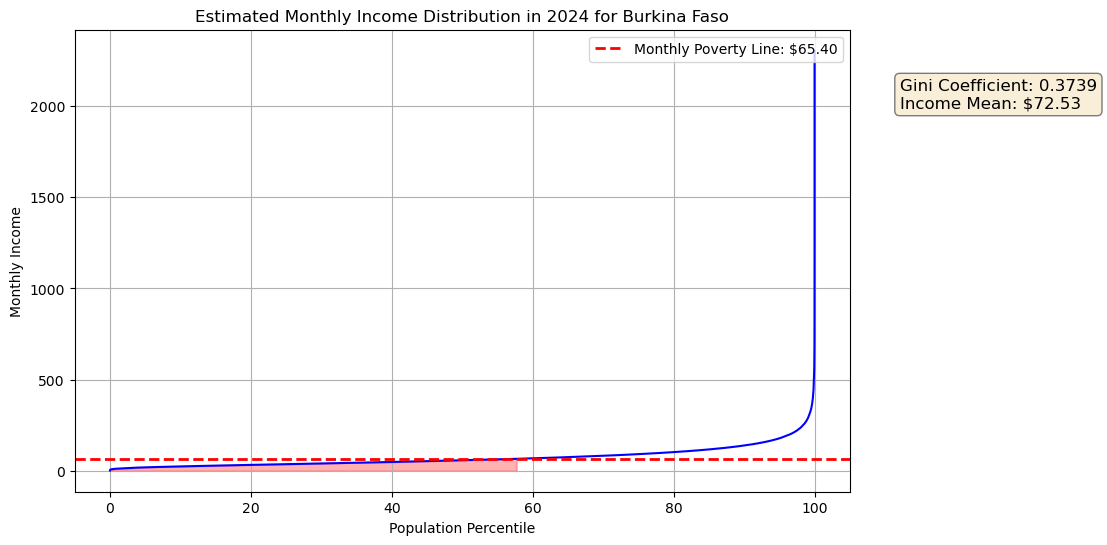

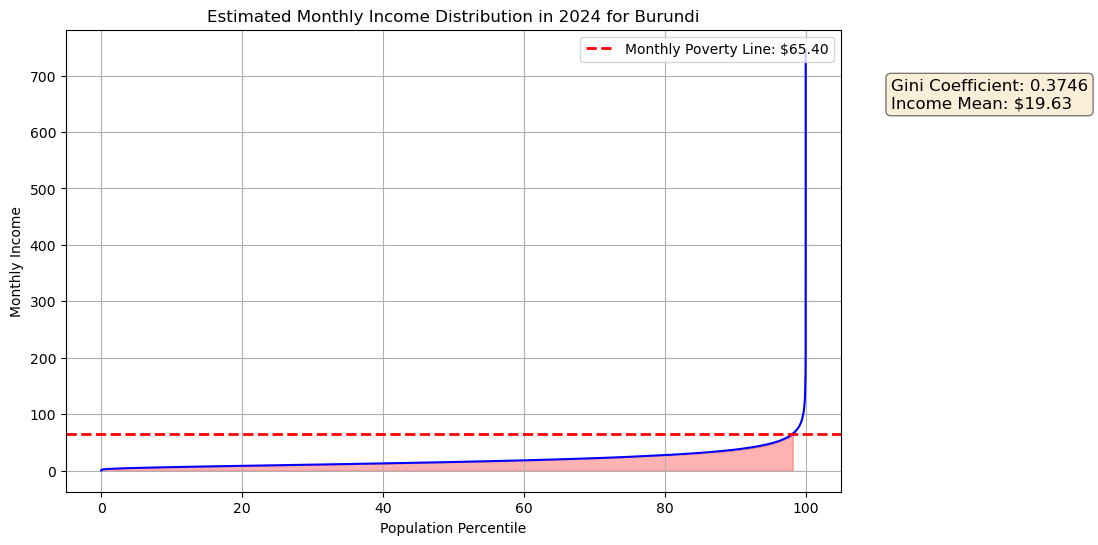

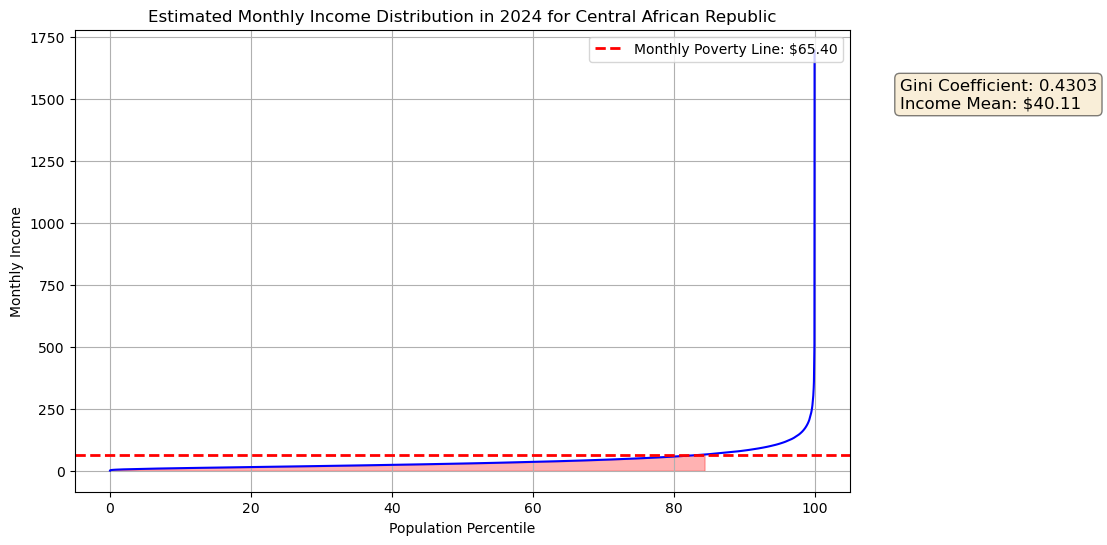

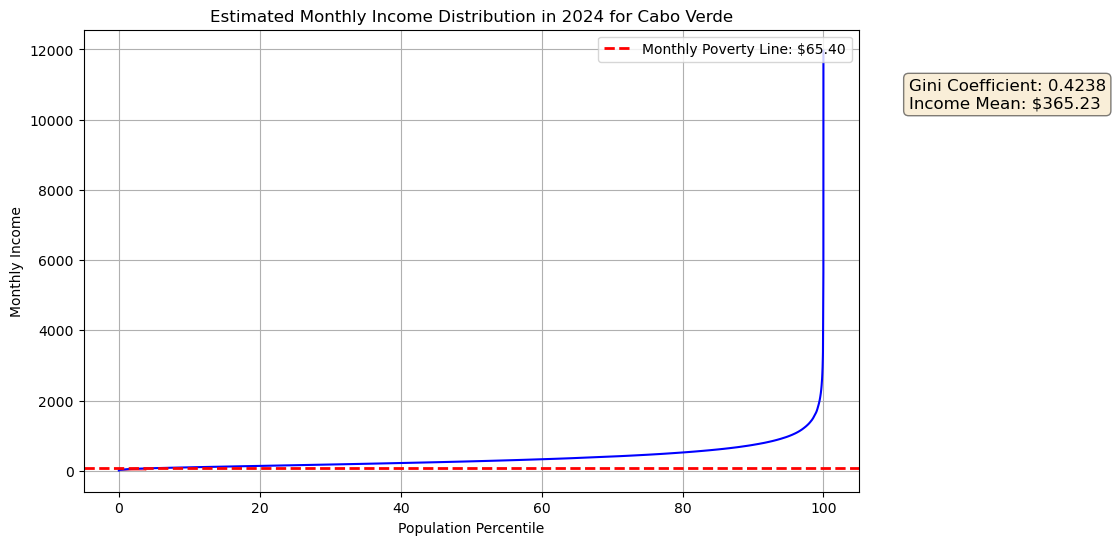

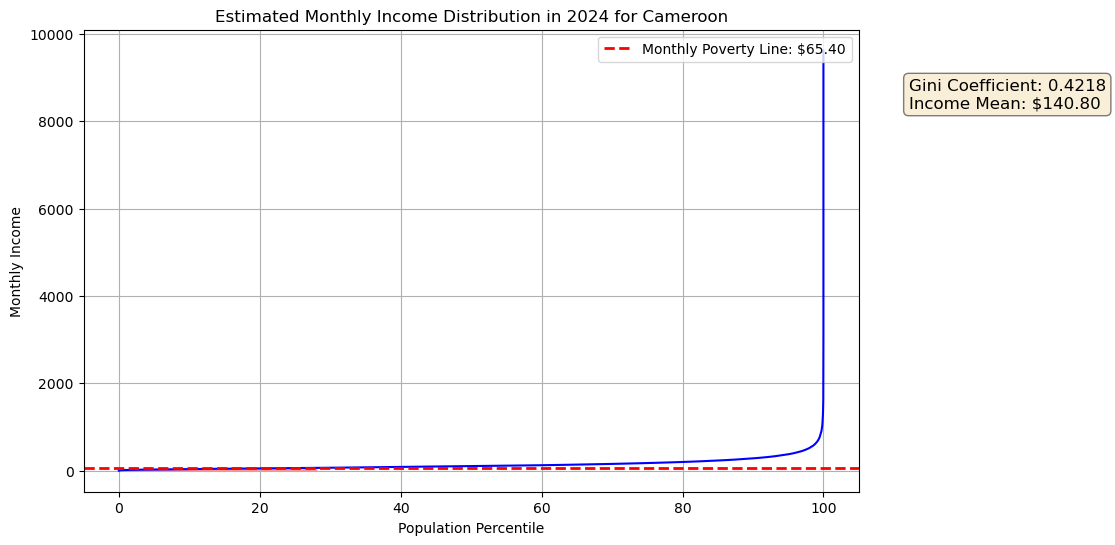

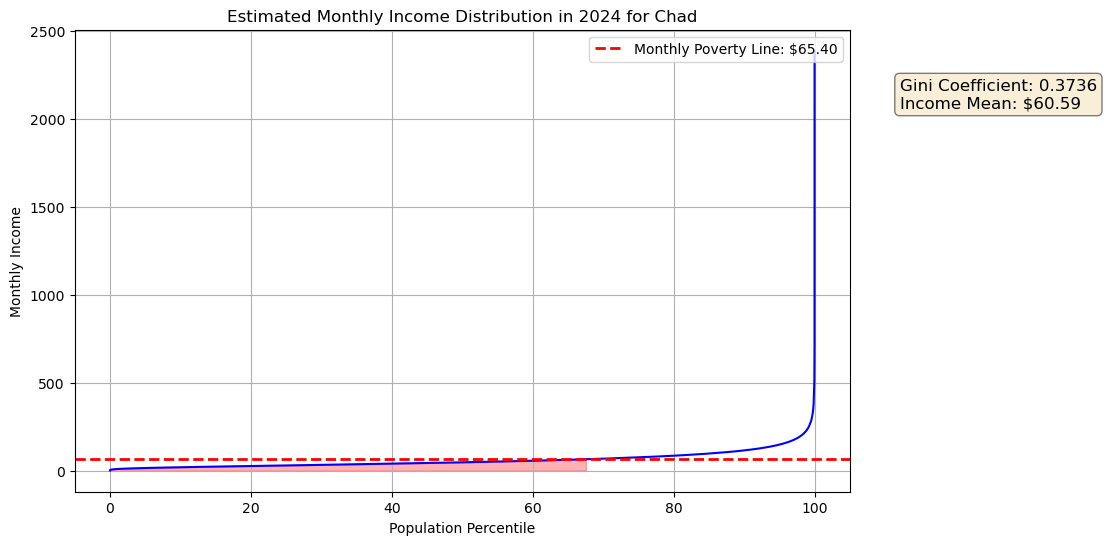

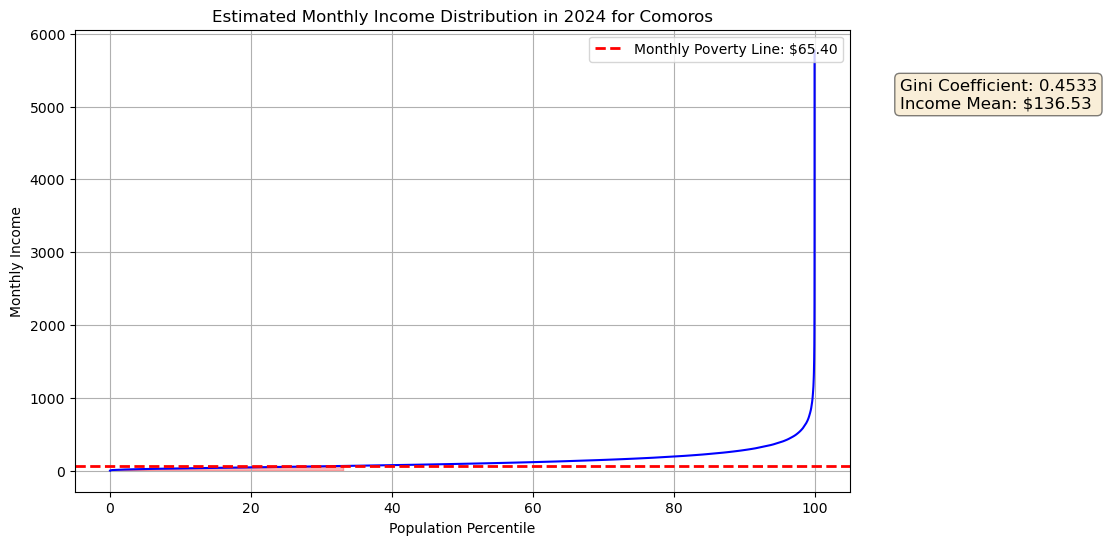

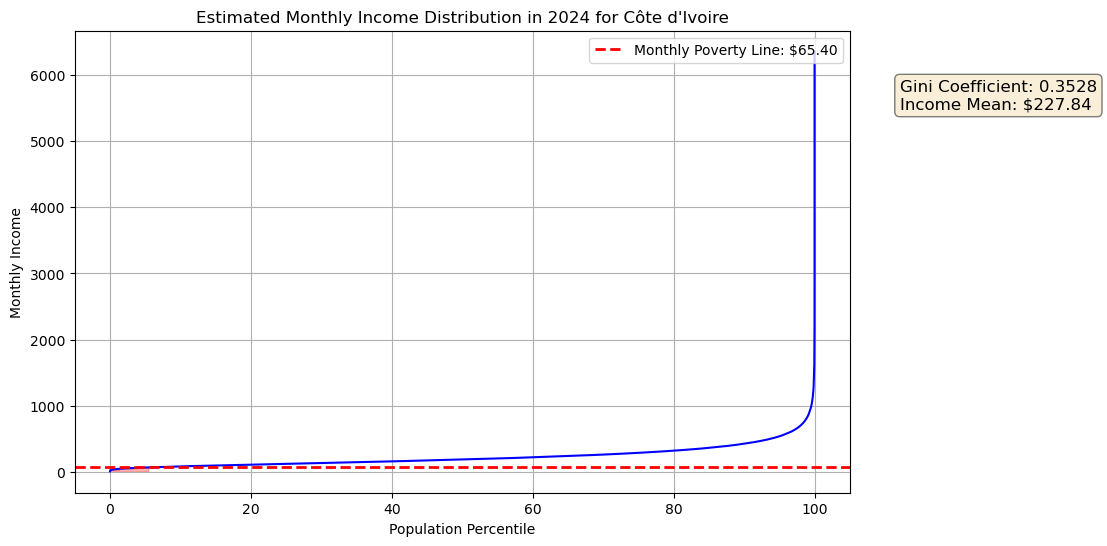

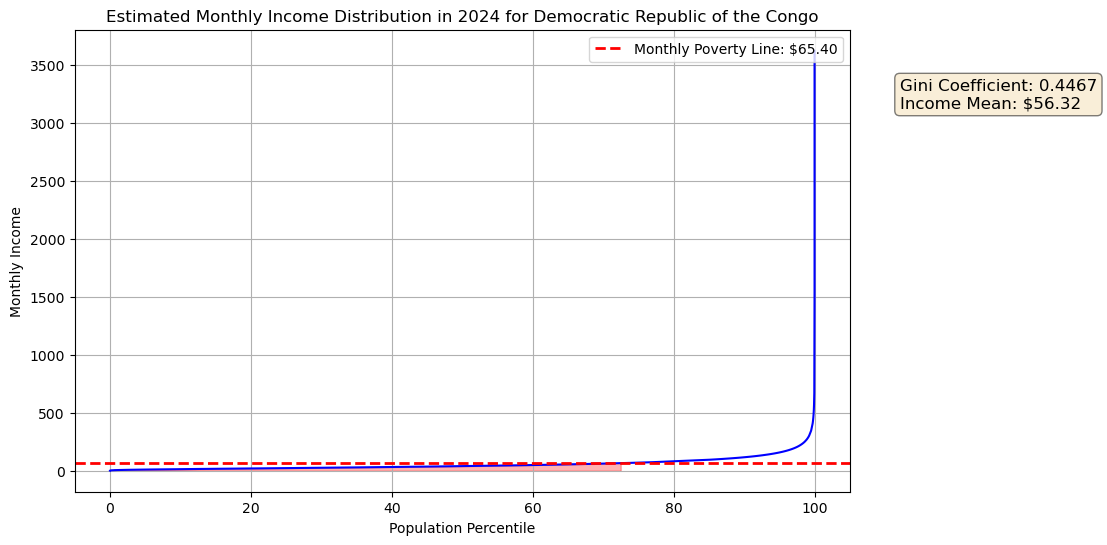

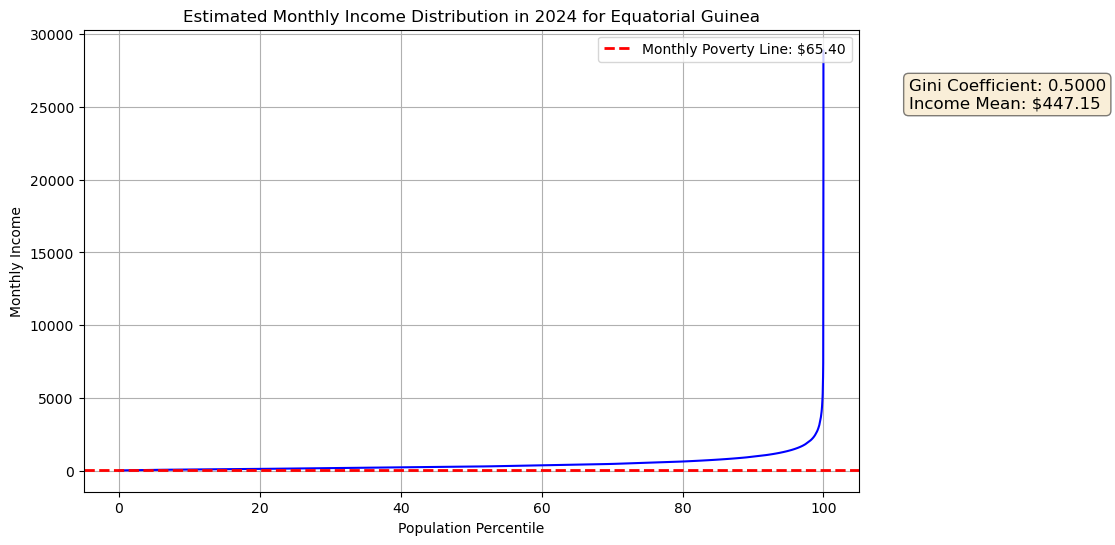

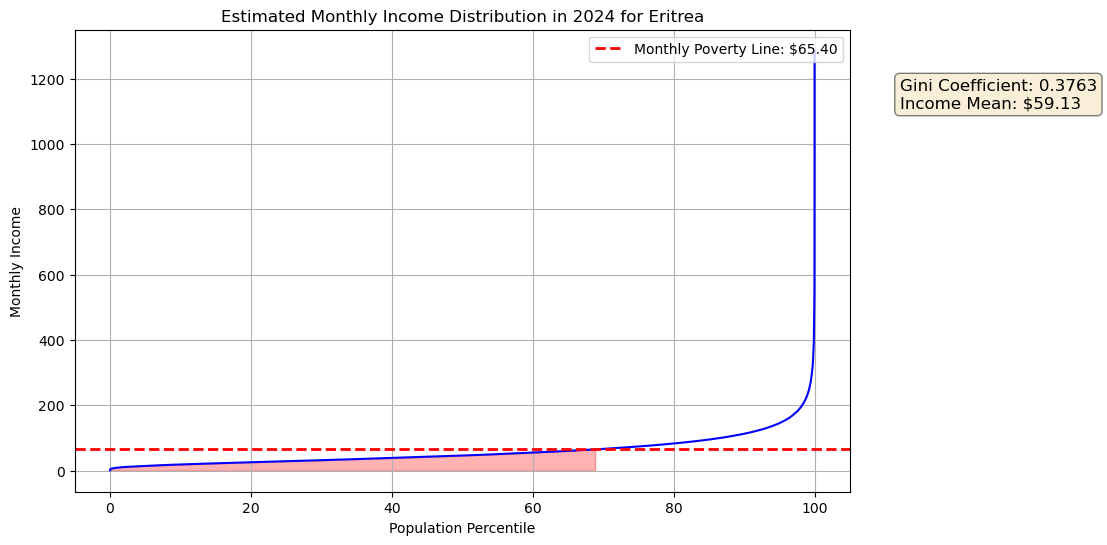

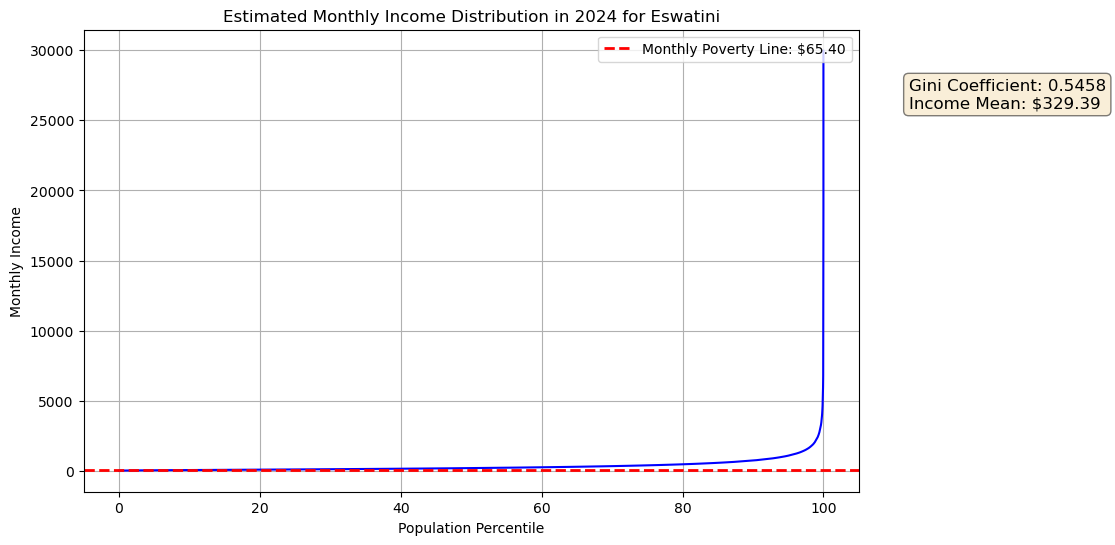

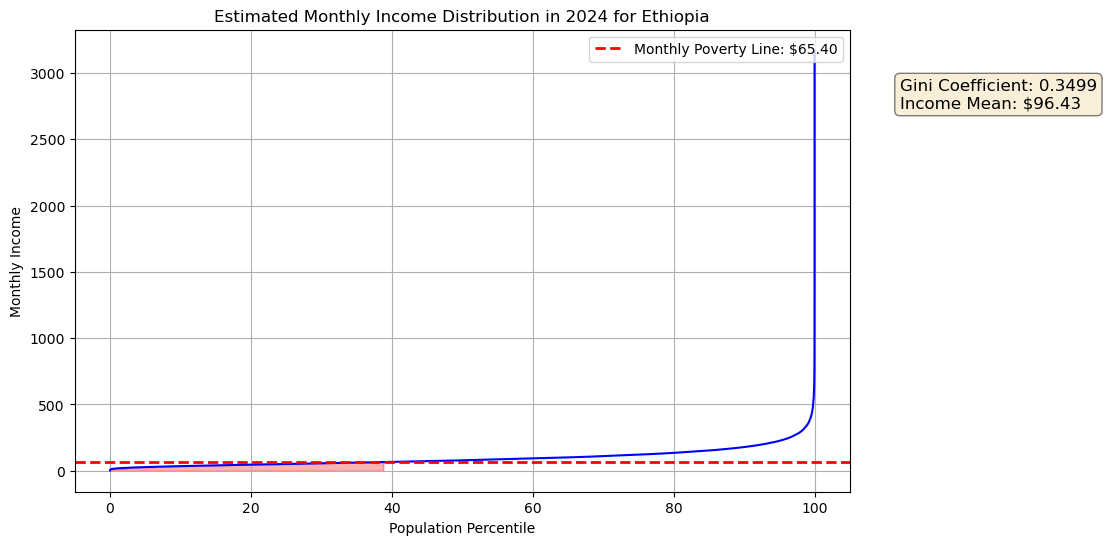

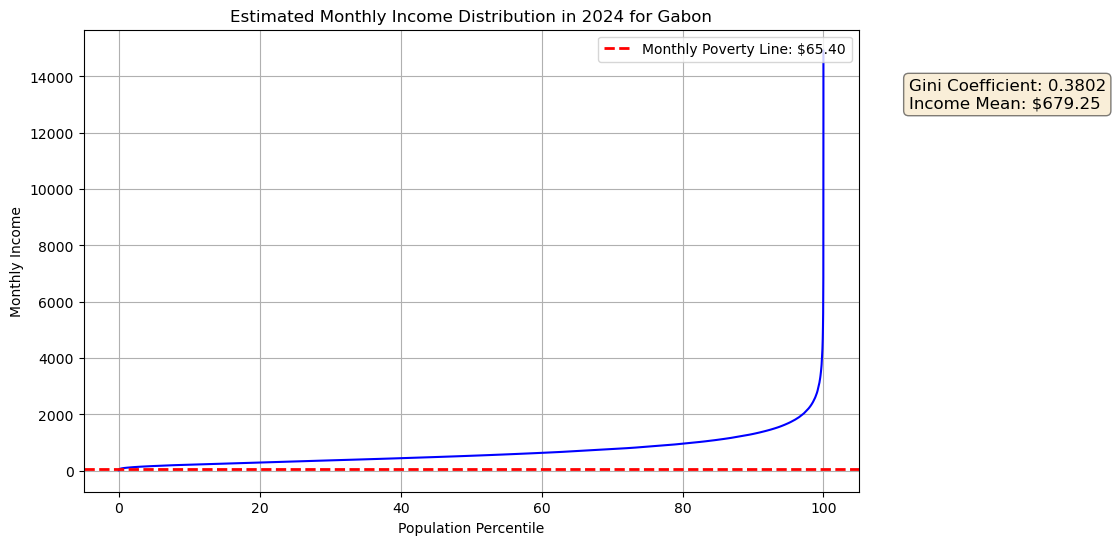

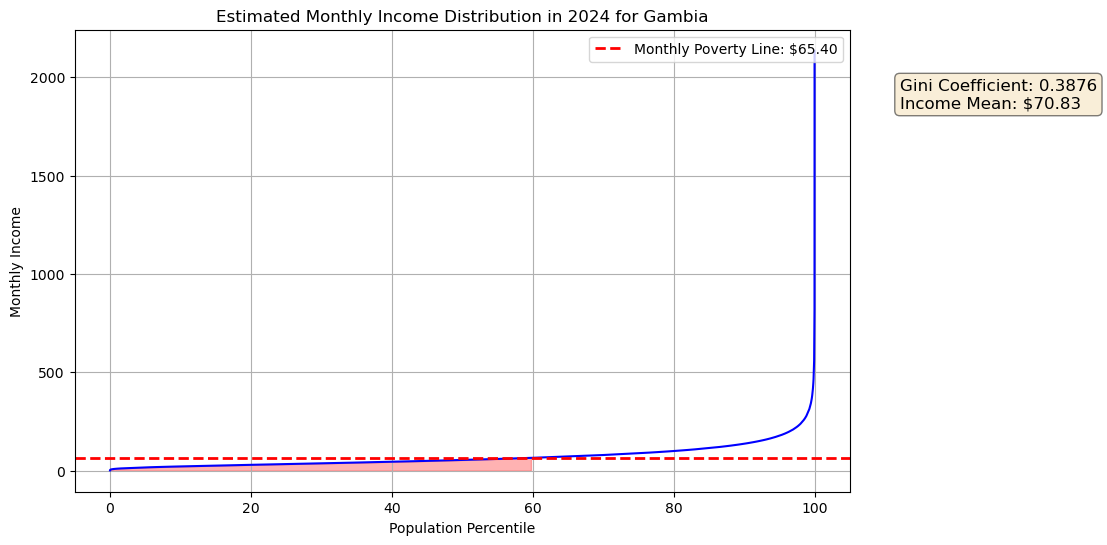

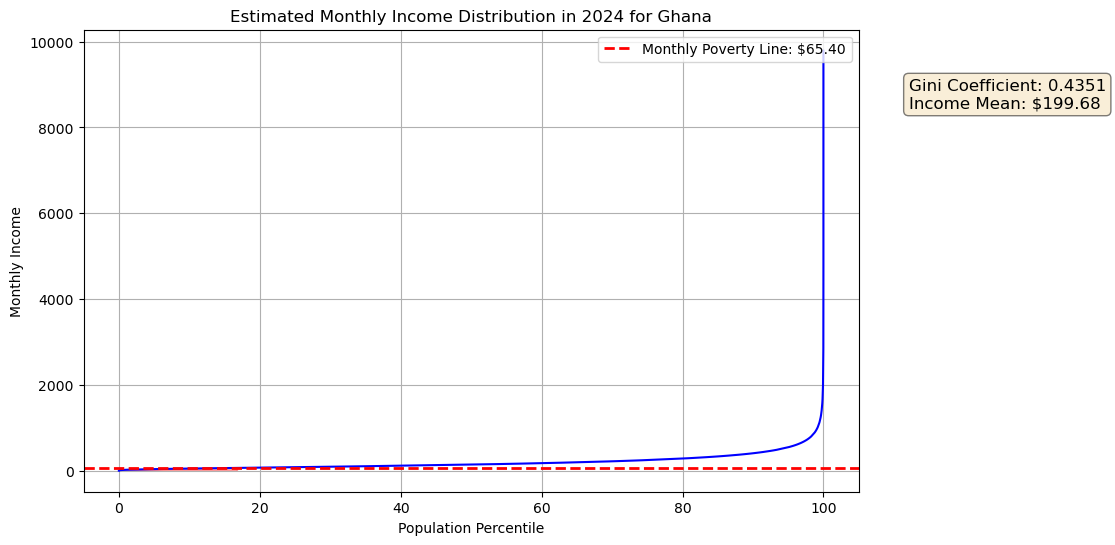

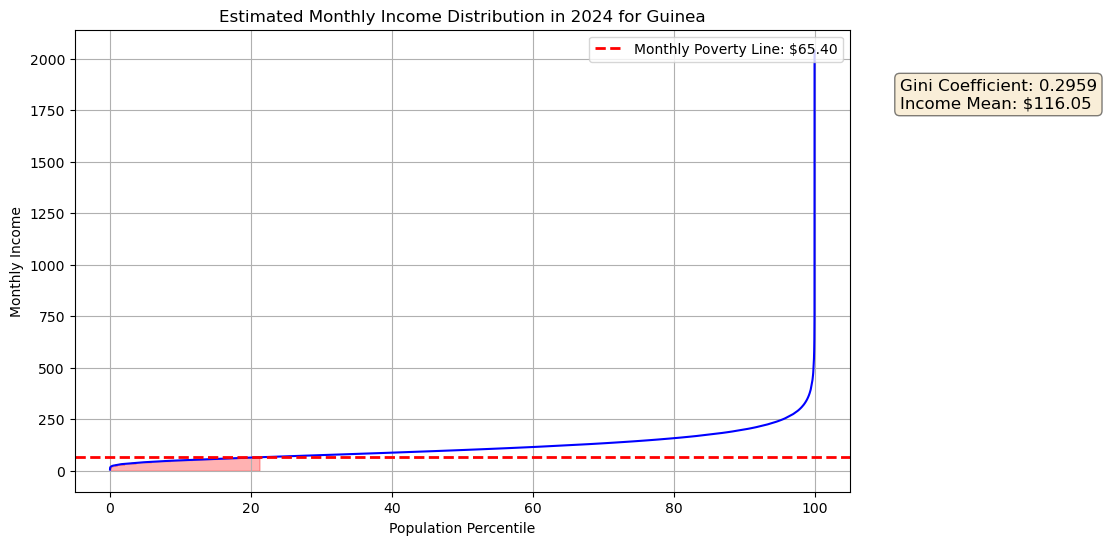

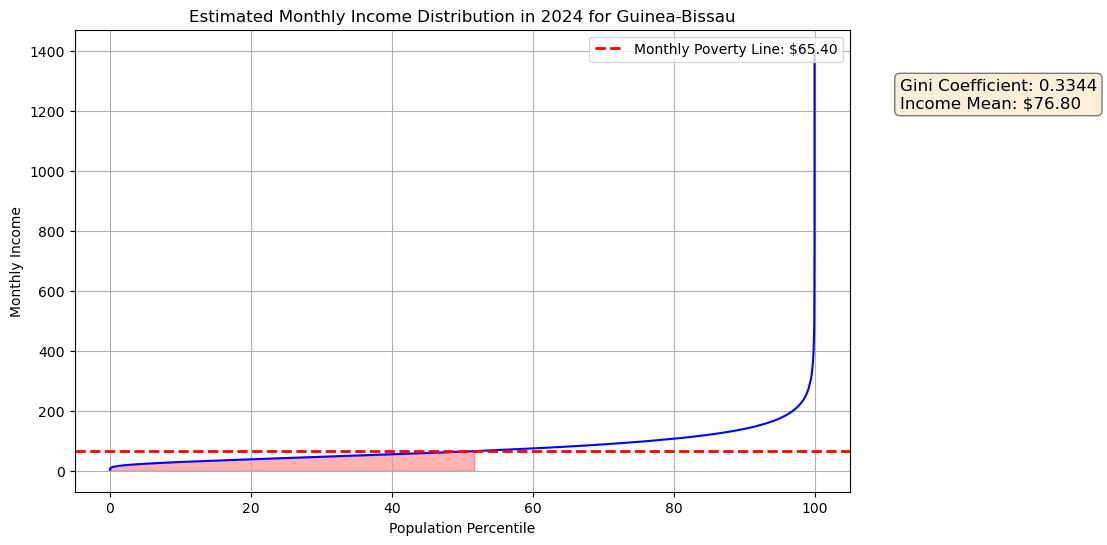

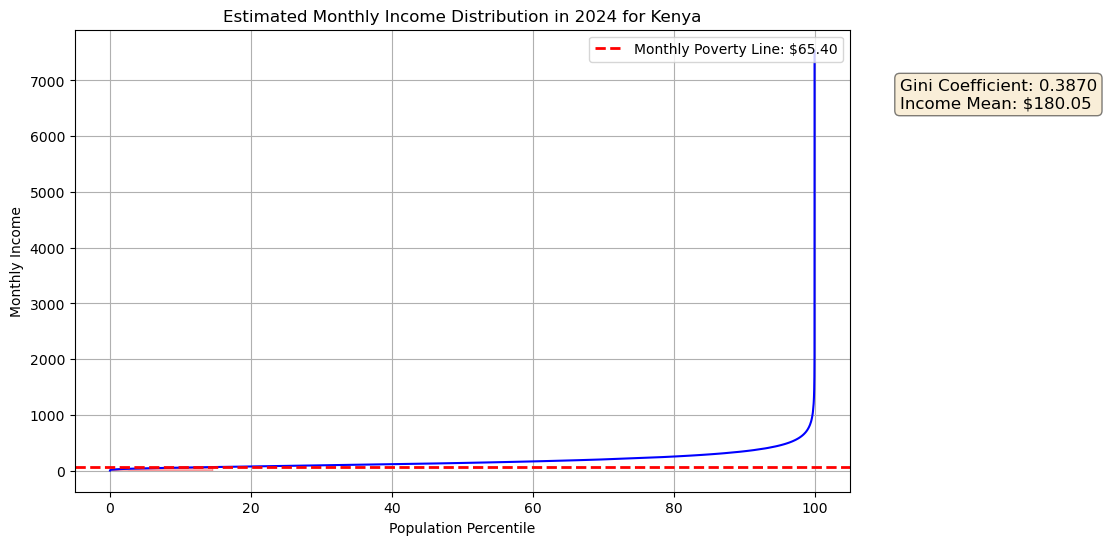

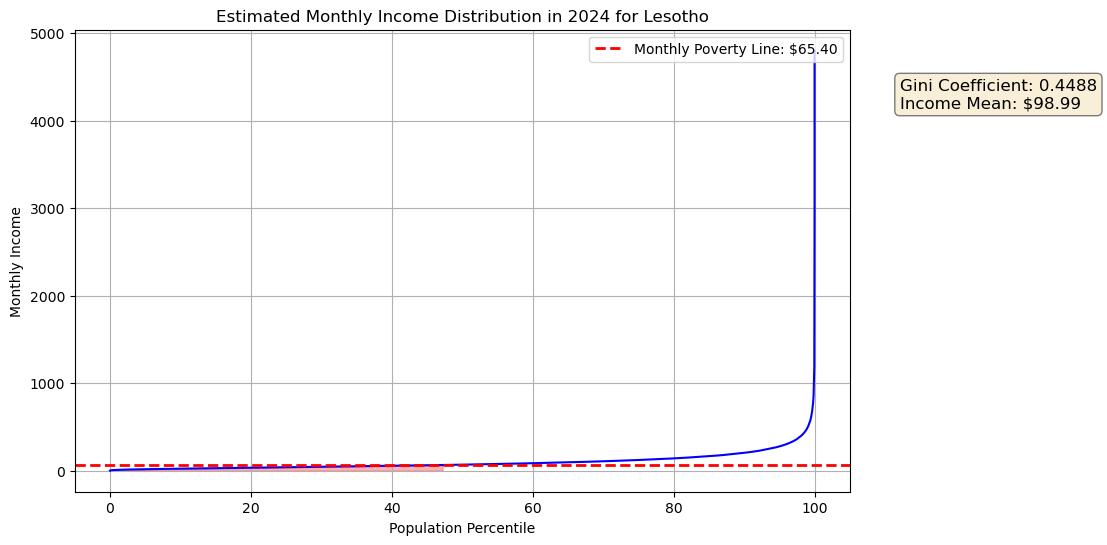

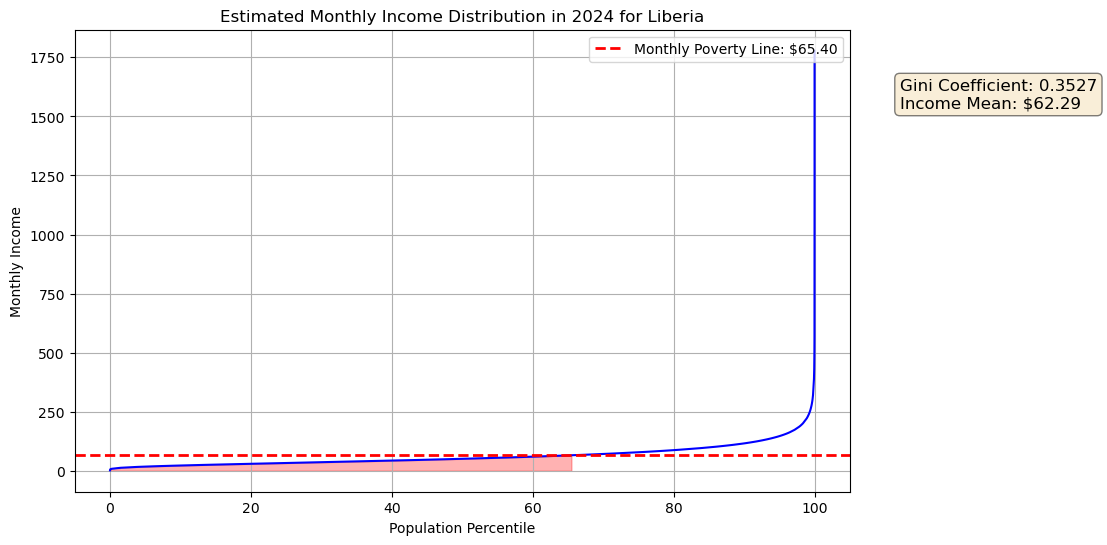

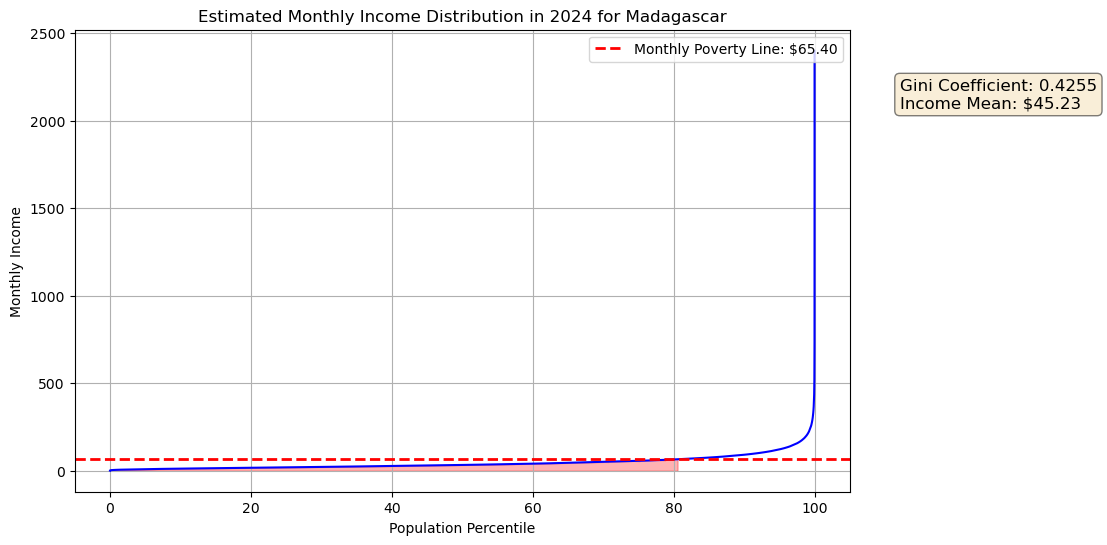

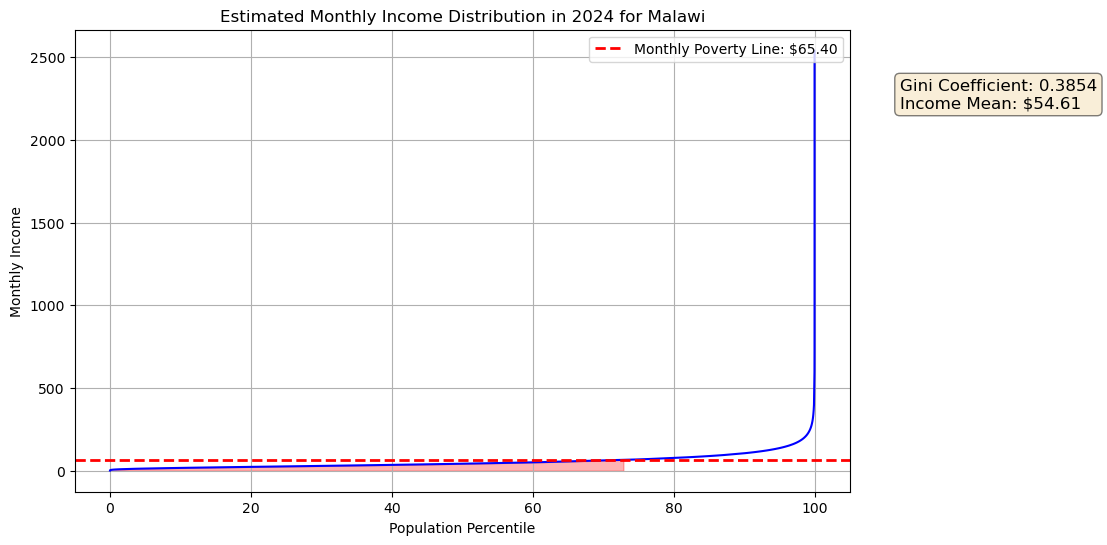

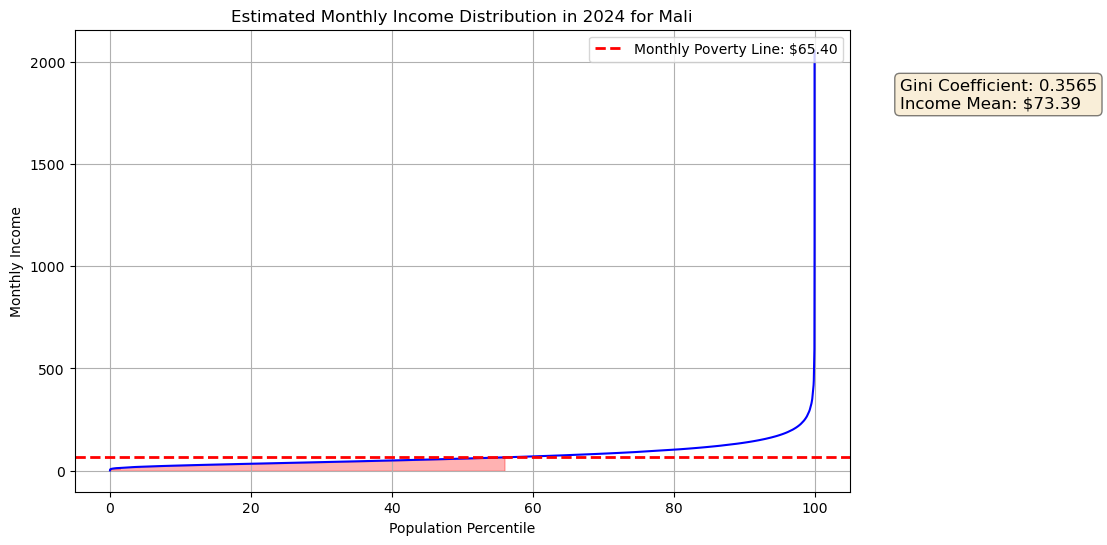

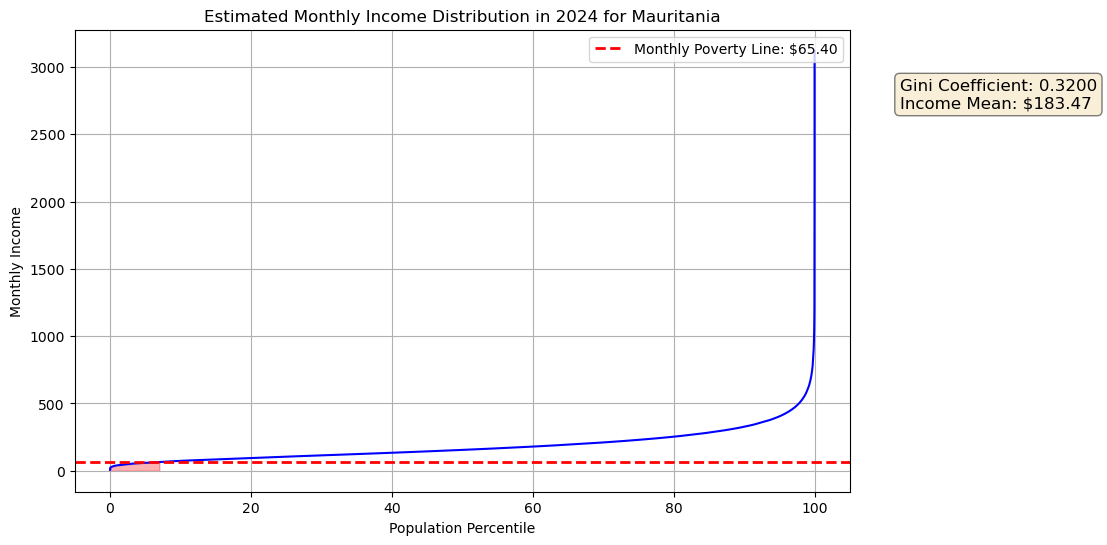

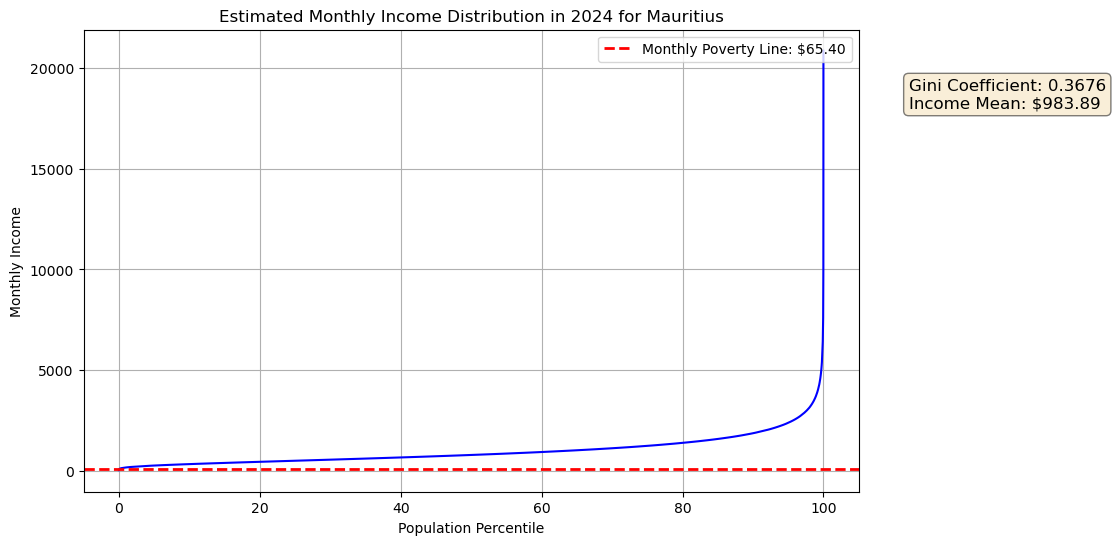

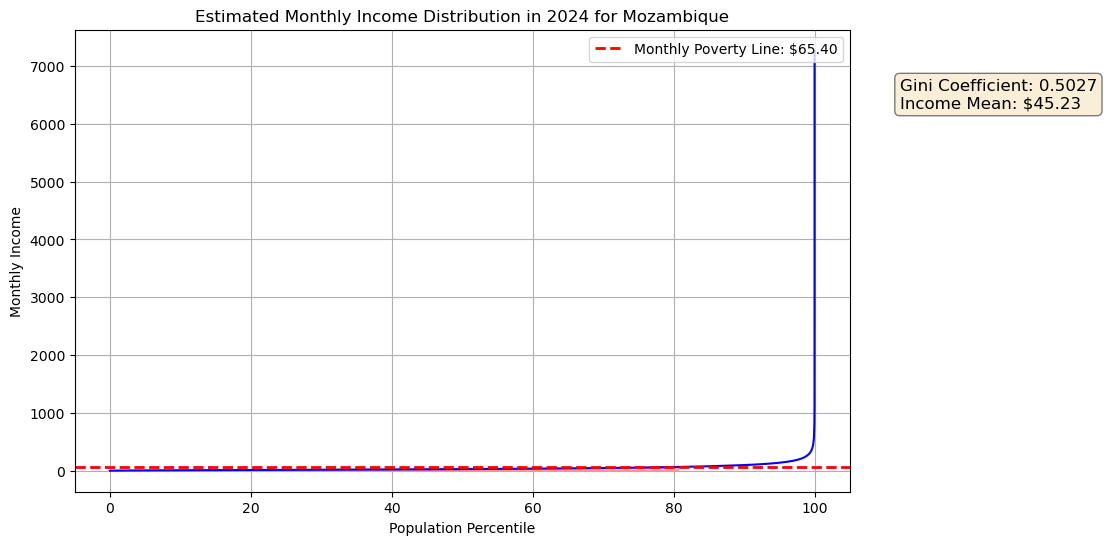

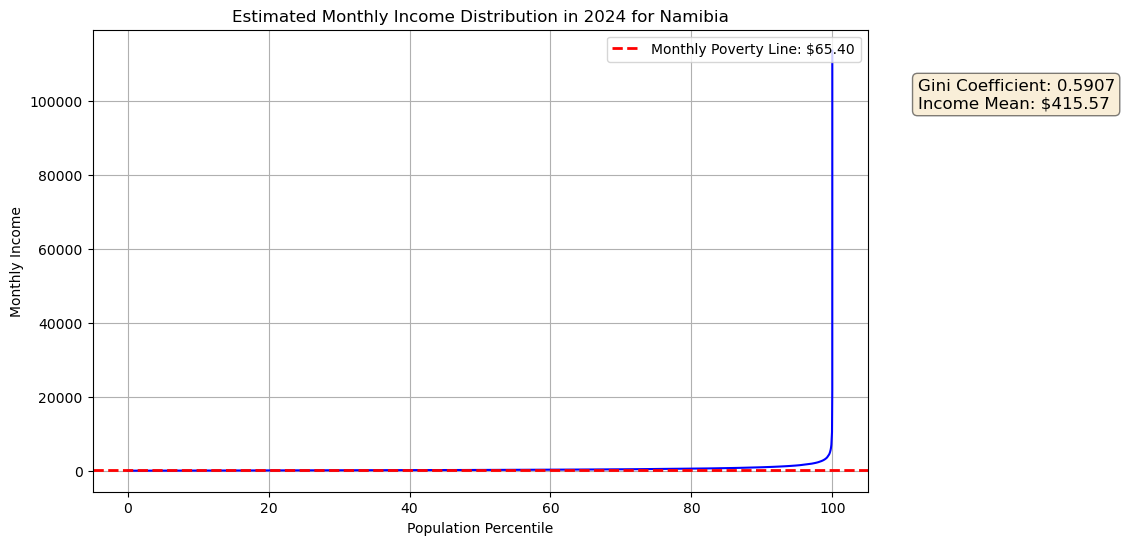

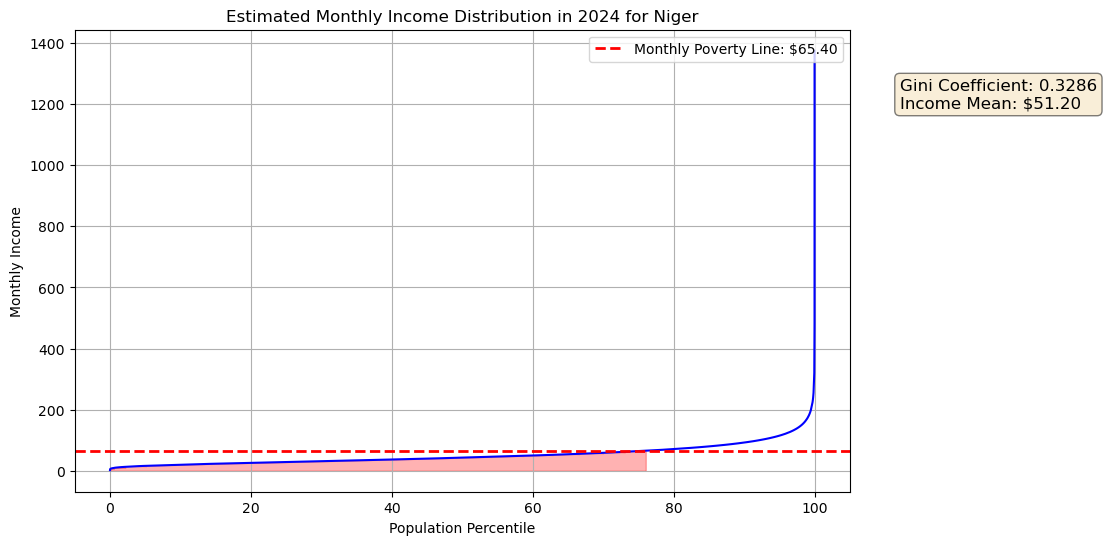

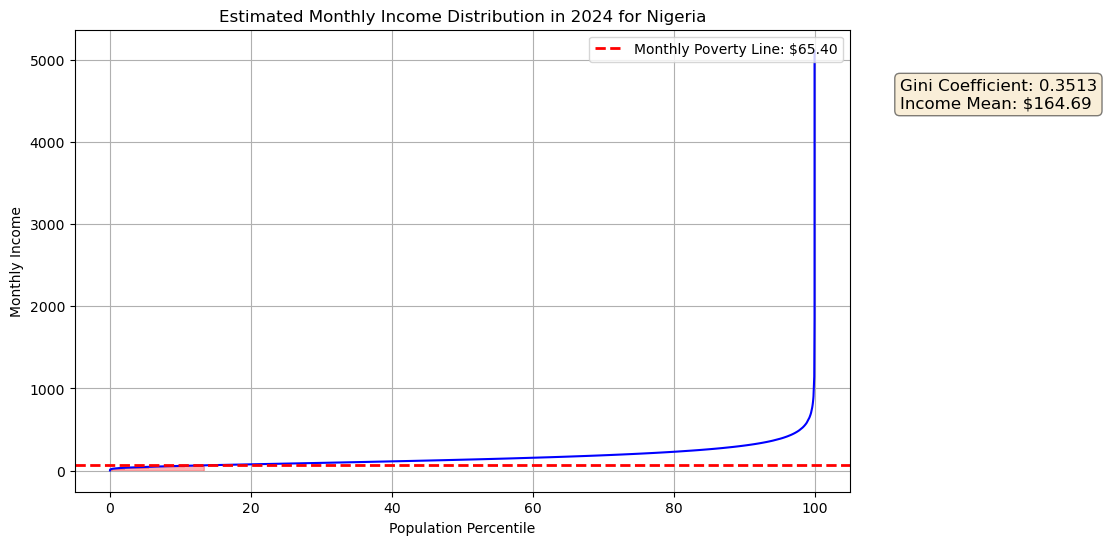

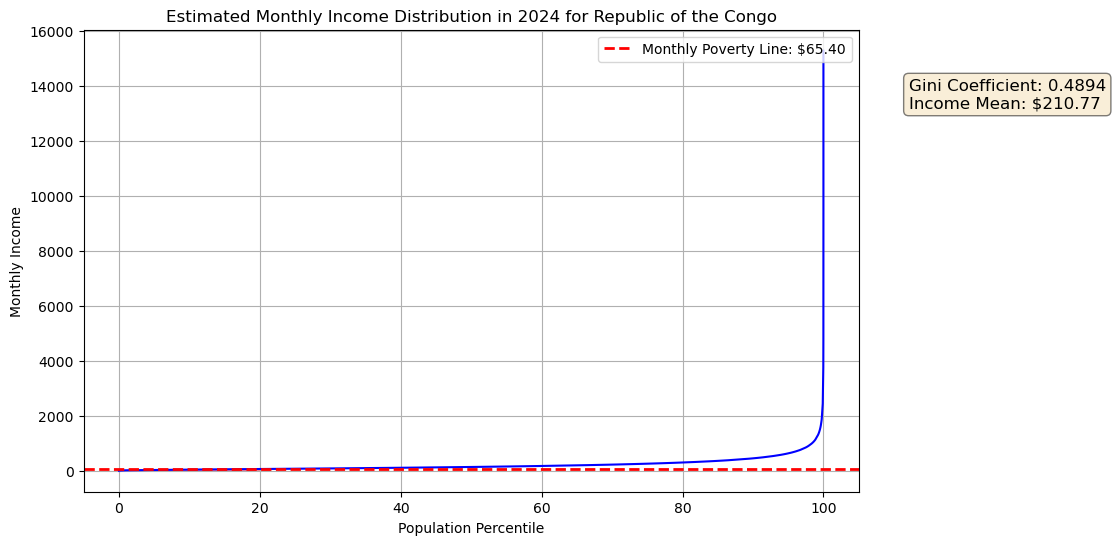

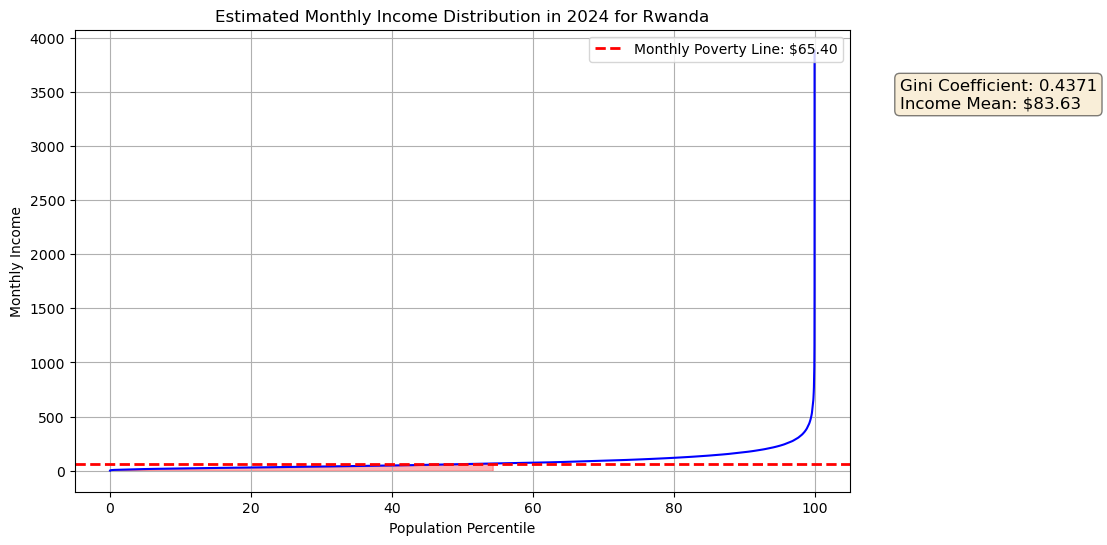

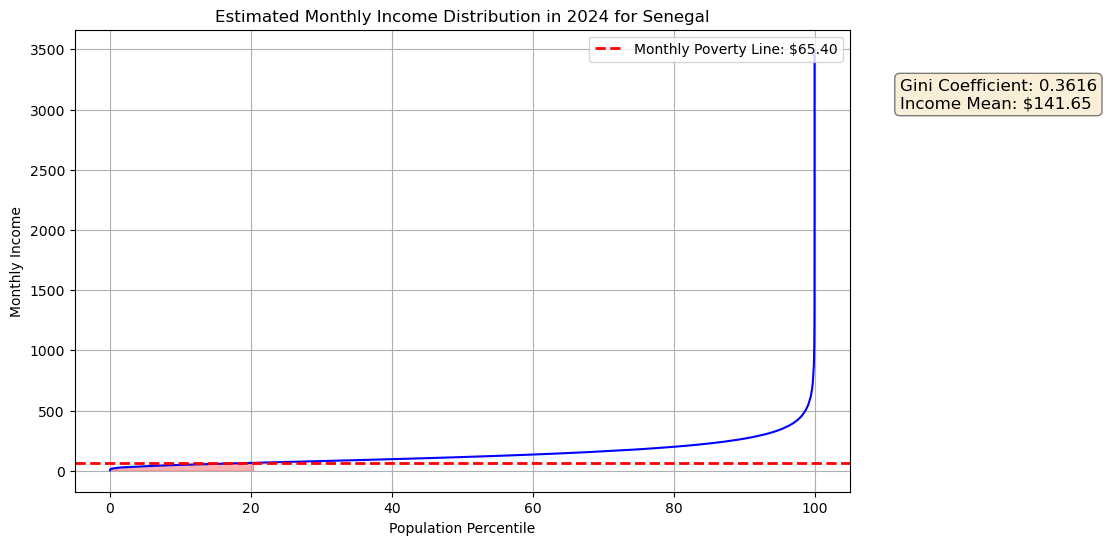

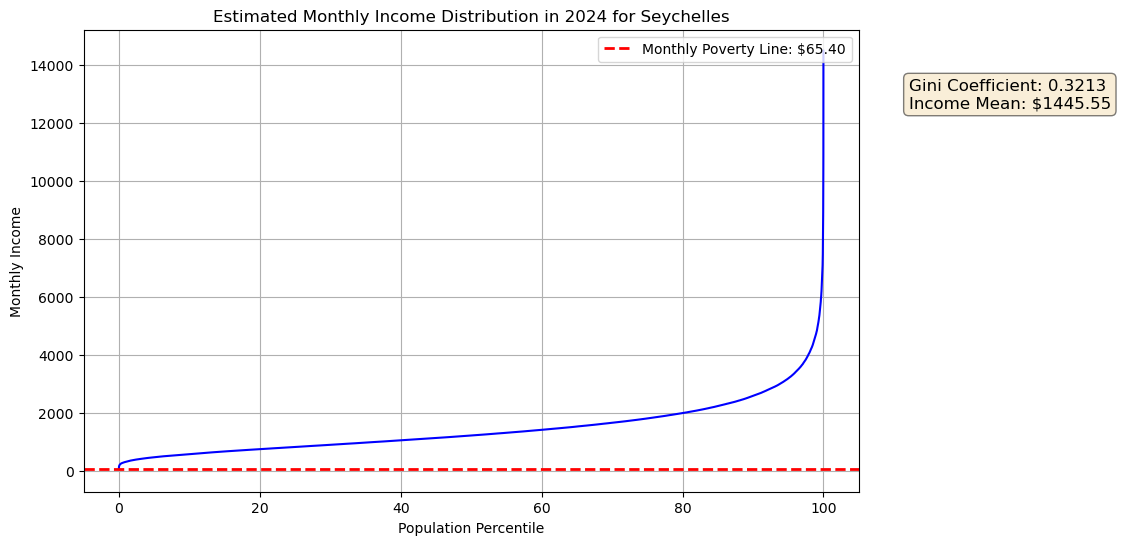

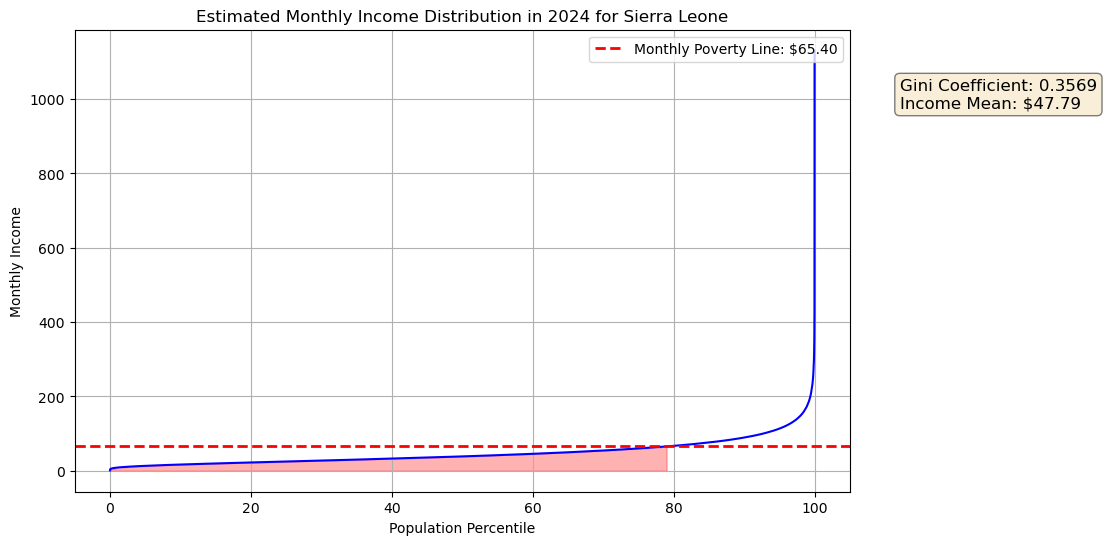

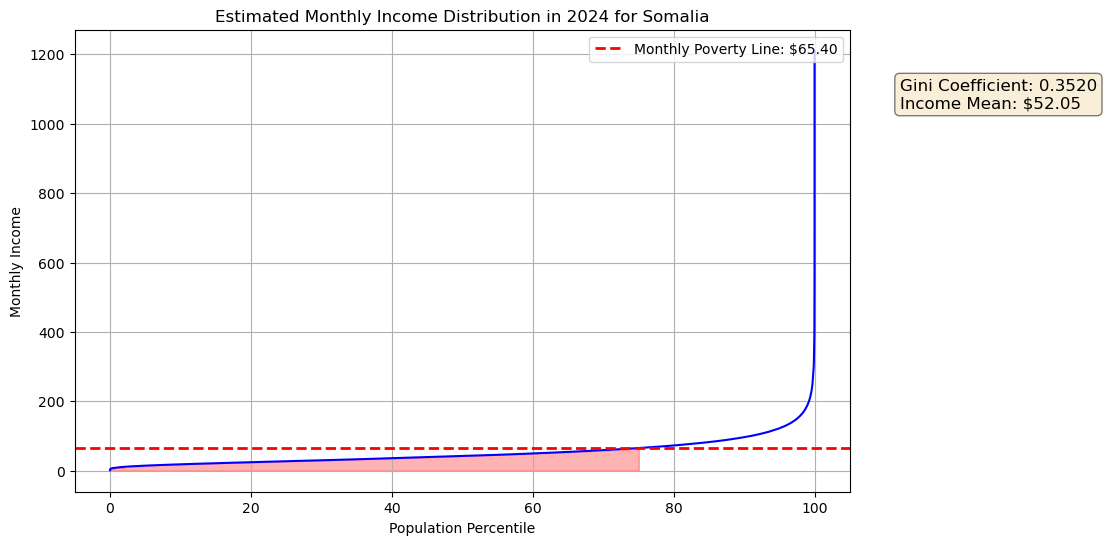

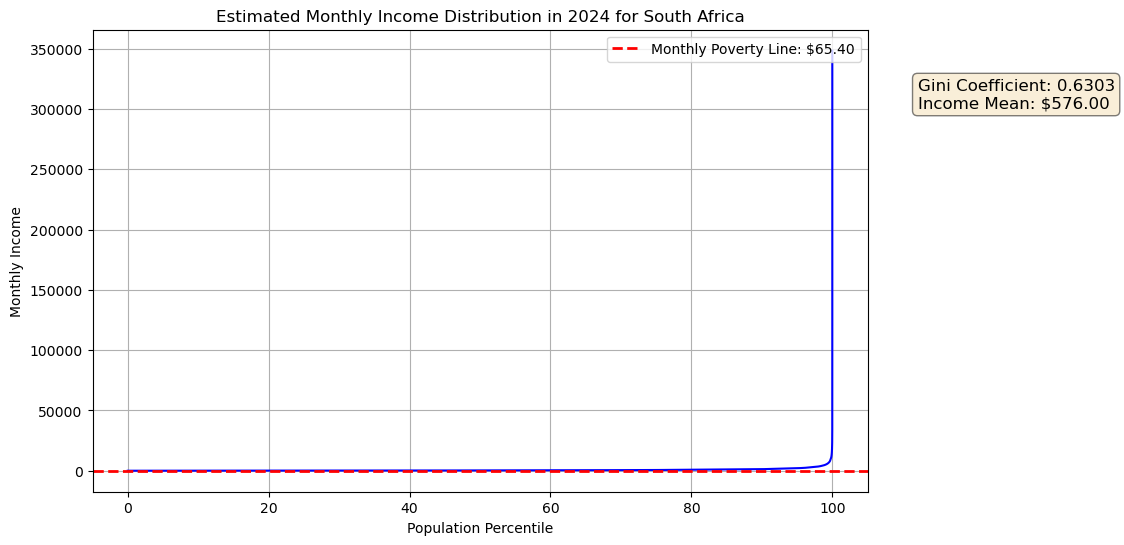

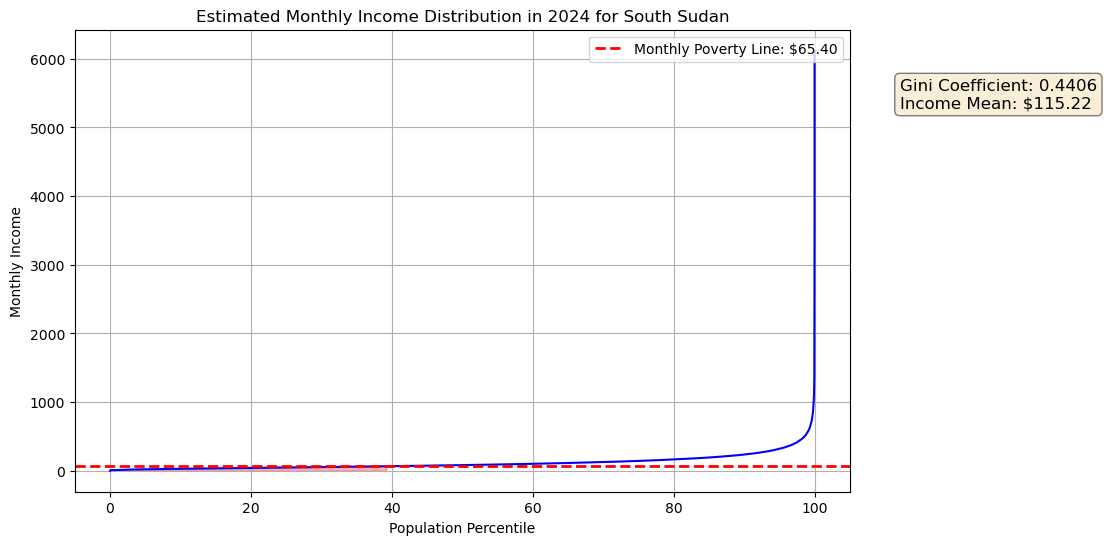

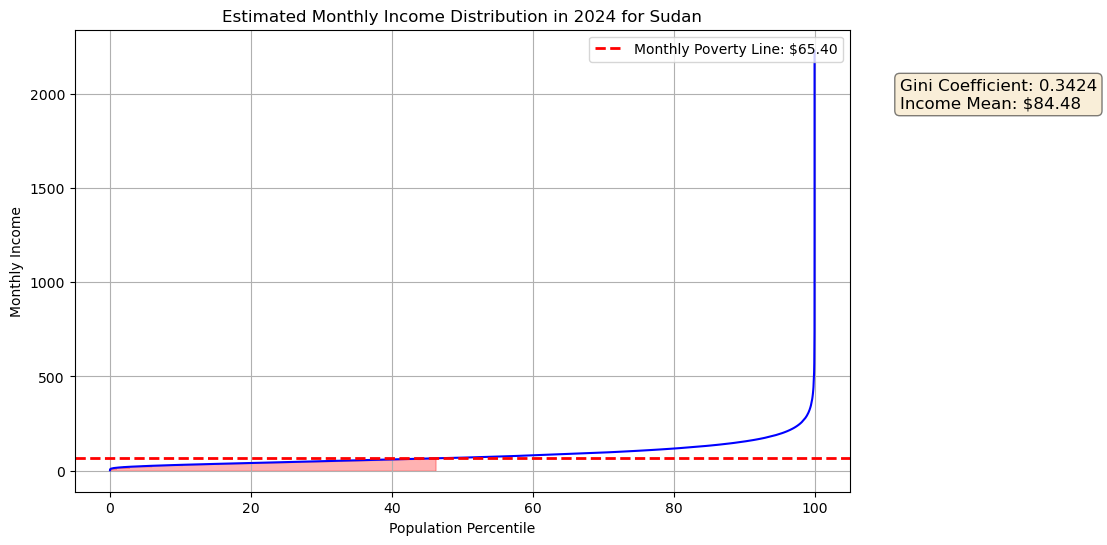

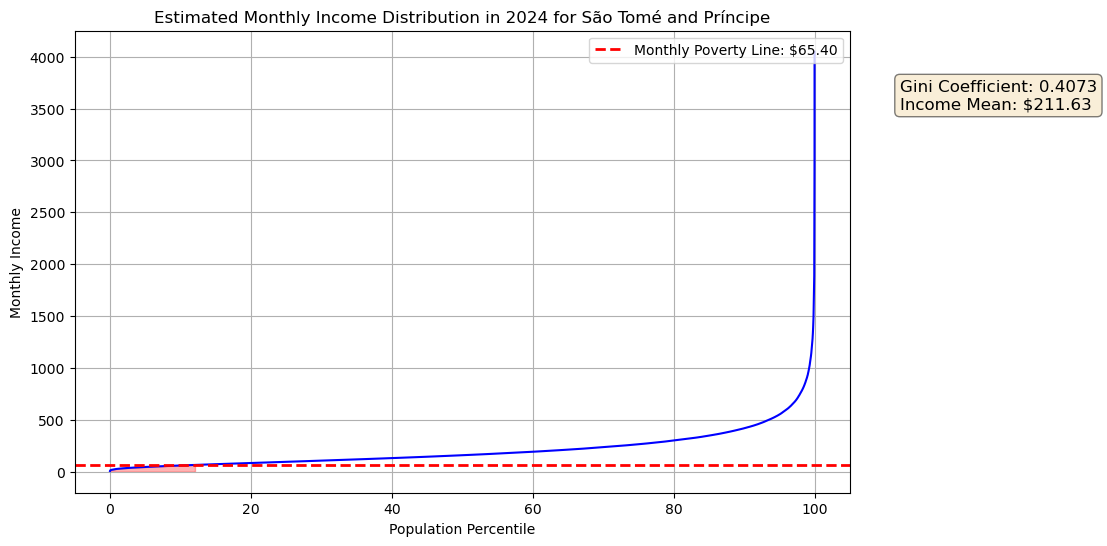

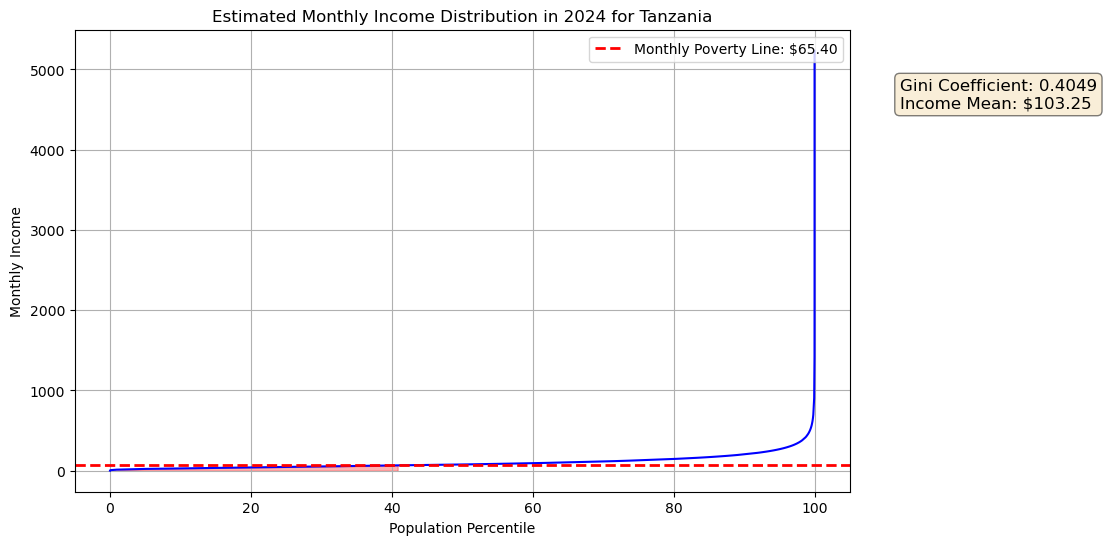

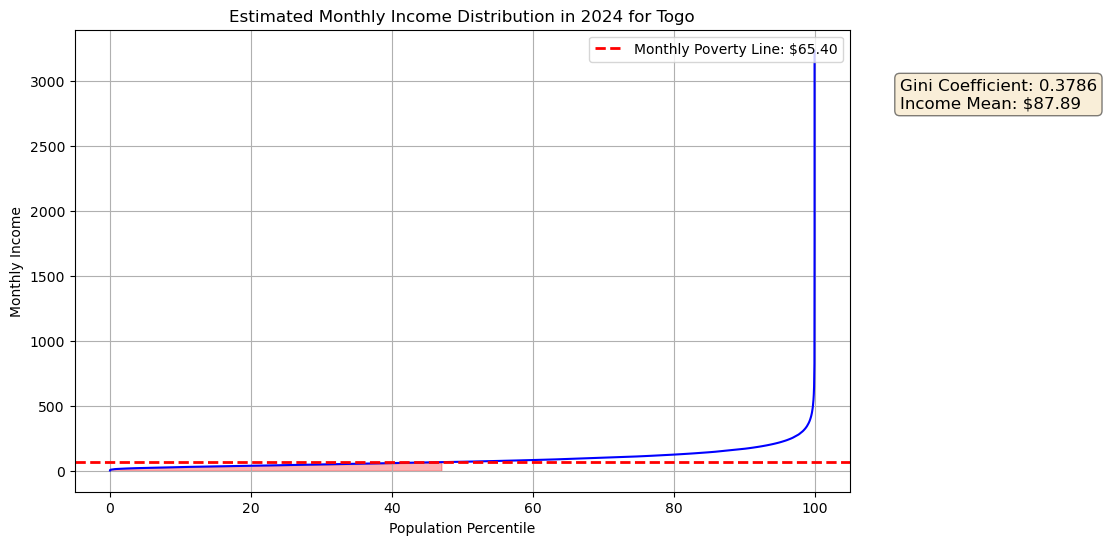

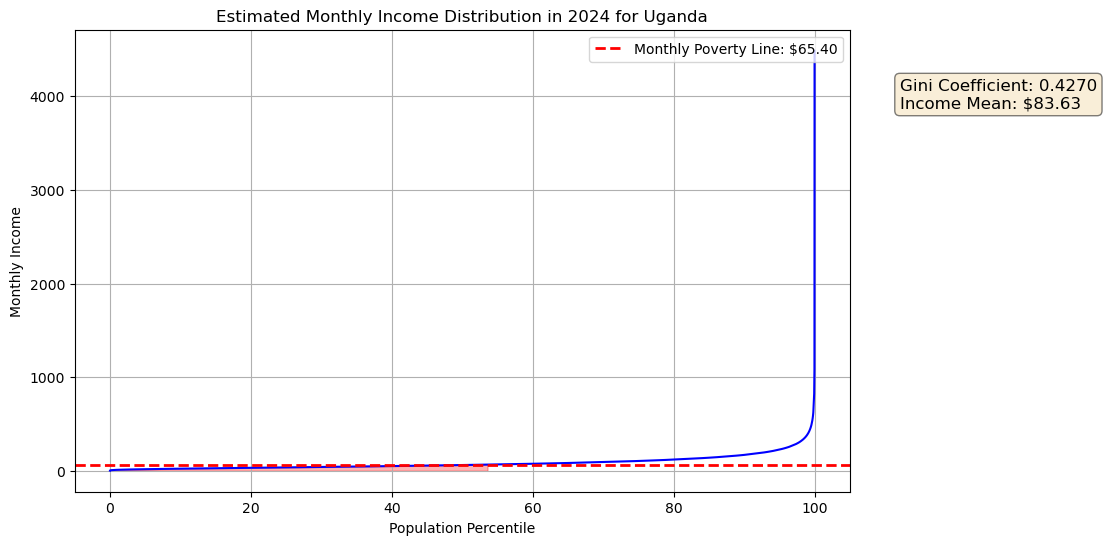

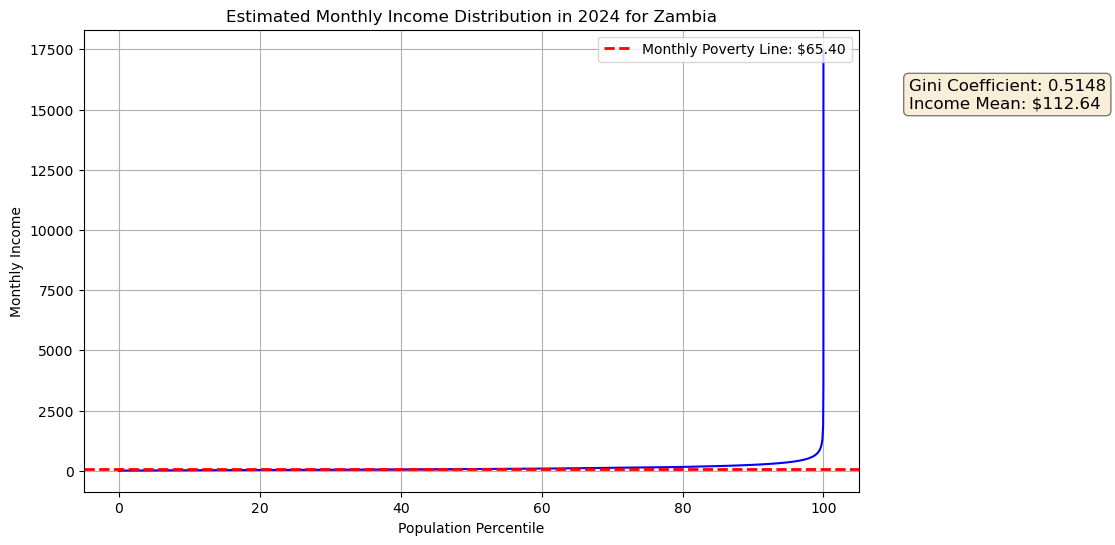

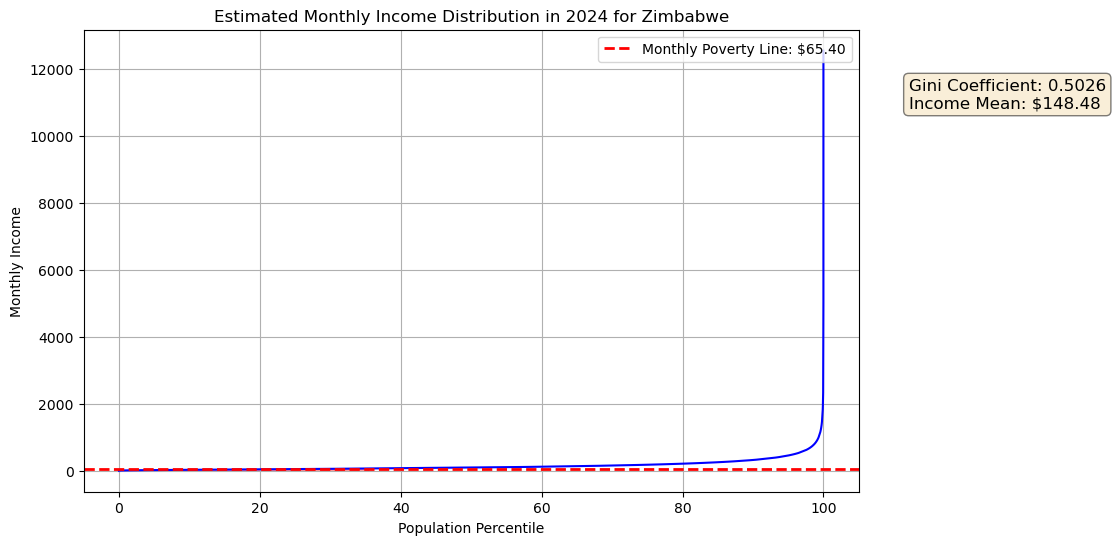

Affordability results exported to /Users/candicekou/Desktop/Country_Affordability_Results.xlsx


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

file_path = '~/Data input.xlsx'
data = pd.read_excel(file_path)
data['Population, total - 2024'] = pd.to_numeric(data['Population, total - 2024'], errors='coerce')
data['Gini Index'] = pd.to_numeric(data['Gini Index'], errors='coerce')

# Assumed poverty line
annual_poverty_line = 2.15 * 365  # World Bank's $2.15/day poverty line, annualized
monthly_poverty_line = annual_poverty_line / 12  # Converted to monthly poverty line

# Function to calculate Gini Coefficient
def calculate_gini(array):
    sorted_array = np.sort(array)
    cumulative_income = np.cumsum(sorted_array)
    relative_income = cumulative_income / cumulative_income[-1]
    relative_population = np.arange(1, len(sorted_array) + 1) / len(sorted_array)
    area_under_lorenz = np.trapz(relative_income, relative_population)
    return 1 - 2 * area_under_lorenz

# Function to adjust distribution to match target Gini coefficient and maintain mean
def adjust_distribution_to_target_gini(initial_distribution, target_gini, target_mean, max_iterations=5000, tolerance=1e-5):
    adjusted_distribution = initial_distribution.copy()
    for _ in range(max_iterations):
        current_gini = calculate_gini(adjusted_distribution)
        current_mean = np.mean(adjusted_distribution)

        if abs(current_gini - target_gini) < tolerance and abs(current_mean - target_mean) < tolerance:
            break

        adjustment_factor_gini = (target_gini / current_gini)**0.5
        adjusted_distribution = (adjusted_distribution**adjustment_factor_gini) * (target_mean / np.mean(adjusted_distribution))

    total_target_income = target_mean * len(adjusted_distribution)
    total_current_income = np.sum(adjusted_distribution)
    scaling_factor = total_target_income / total_current_income
    adjusted_distribution *= scaling_factor

    return adjusted_distribution

# Set random seed for reproducibility
np.random.seed(42)

# Initialize results storage
country_results = []

# Process each country sequentially
for _, row in data.iterrows():
    country_name = row['Country']
    gni_per_capita_2022 = row['GNI per capita, Atlas method US$ -2024']
    population_2024 = int(row['Population, total - 2024'])
    gini_coefficient_target = row['Gini Index']

    # Generate initial income distribution using a log-normal distribution
    mean_income = gni_per_capita_2022 / 12  # Convert annual GNI per capita to monthly income
    sigma = 0.5
    mean_log_income = np.log(mean_income) - 0.5 * sigma**2
    income_distribution = np.random.lognormal(mean_log_income, sigma, population_2024)

    # Adjust the distribution
    adjusted_income_distribution = adjust_distribution_to_target_gini(income_distribution, gini_coefficient_target, mean_income)

    # Calculate affordability for each percentile and energy tier
    for percentile in range(1, 101):
        income_at_percentile = np.percentile(adjusted_income_distribution, percentile)
        for tier in ['Tier 1', 'Tier 2', 'Tier 3', 'Tier 4', 'Tier 5']:
            monthly_cost = row[tier]
            affordability_percent = (monthly_cost / income_at_percentile) * 100 if income_at_percentile > 0 else None

            # Store the result
            country_results.append({
                'Country': country_name,
                'Percentile': percentile,
                'Energy Tier': tier,
                'Monthly Cost': monthly_cost,
                'Income at Percentile': income_at_percentile,
                'Affordability (%)': affordability_percent
            })

    # Plot income distribution curve for the current country
    income_distribution_sorted = np.sort(adjusted_income_distribution)
    population_percentile = np.linspace(0, 100, population_2024)

    plt.figure(figsize=(10, 6))
    plt.plot(population_percentile, income_distribution_sorted, color='b')
    plt.axhline(monthly_poverty_line, color='r', linestyle='dashed', linewidth=2, label=f'Monthly Poverty Line: ${monthly_poverty_line:.2f}')
    plt.fill_between(population_percentile, 0, income_distribution_sorted, where=(income_distribution_sorted < monthly_poverty_line), color='red', alpha=0.3)

    # Add a box for income mean and Gini coefficient
    adjusted_gini = calculate_gini(adjusted_income_distribution)
    adjusted_mean_income = np.mean(adjusted_income_distribution)
    textstr = f'Gini Coefficient: {adjusted_gini:.4f}\nIncome Mean: ${adjusted_mean_income:.2f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gcf().text(0.95, 0.75, textstr, fontsize=12, bbox=props)

    plt.title(f'Estimated Monthly Income Distribution in 2024 for {country_name}')
    plt.xlabel('Population Percentile')
    plt.ylabel('Monthly Income')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Convert results to DataFrame
results_df = pd.DataFrame(country_results)

# Save results to an Excel file
output_file_path = '~/Country_Affordability_Results.xlsx'
results_df.to_excel(output_file_path, index=False)
print(f"Affordability results exported to {output_file_path}")
